### Importing all the libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pylab as plt
%matplotlib inline

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import itertools

In [2]:
d = pd.read_csv("E:\Data Science Internship\Coding Raja\Time Series Forecasting\Electric_Production.csv")
d.head(4)

,DATE,Value
0,01-01-1985,72.5052
1,02-01-1985,70.6720
2,03-01-1985,62.4502
3,04-01-1985,57.4714


In [3]:
d_production = d

### Converting to datetype:

In [4]:
d_production['DATE'] = pd.to_datetime(d_production['DATE'])

In [5]:
d_production.head(5)

,DATE,Value
0,1985-01-01,72.5052
1,1985-02-01,70.6720
2,1985-03-01,62.4502
3,1985-04-01,57.4714
4,1985-05-01,55.3151


In [6]:
#making date as index

d_production.index = d_production['DATE']


In [7]:
d_production.columns = ['date','production']

In [8]:
d_production.head(4)

,date,production
DATE,,
1985-01-01,1985-01-01,72.5052
1985-02-01,1985-02-01,70.6720
1985-03-01,1985-03-01,62.4502
1985-04-01,1985-04-01,57.4714


### Plotting the data:

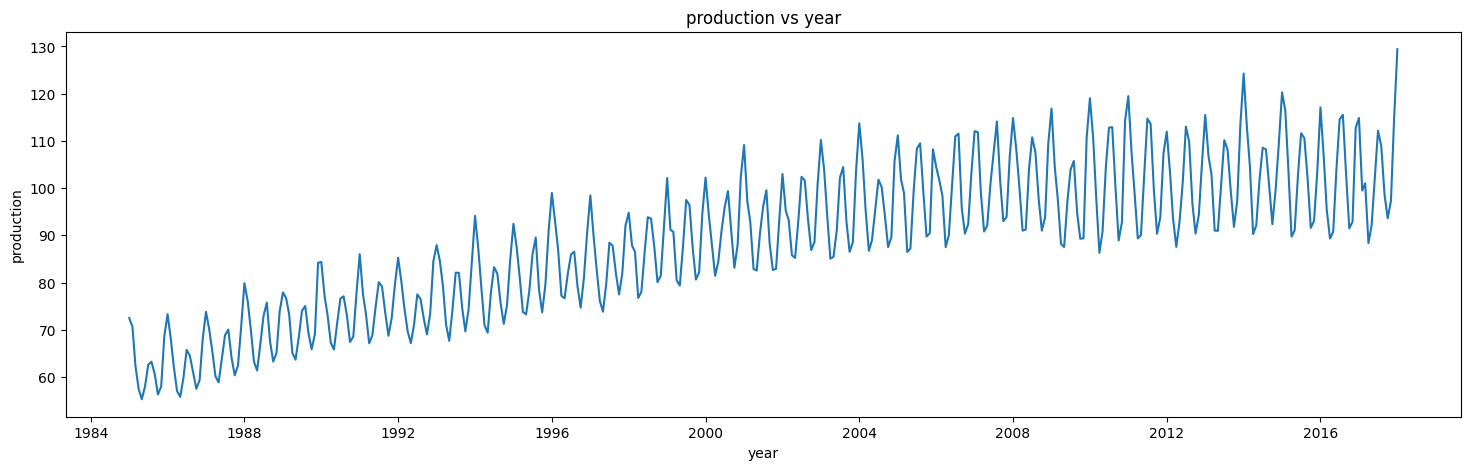

In [9]:
plt.figure(figsize=(18,5))
plt.plot(d_production.index, d_production['production'])
plt.title('production vs year')
plt.xlabel('year')
plt.ylabel('production')
plt.show()

### Getting sesonality and trend of data:

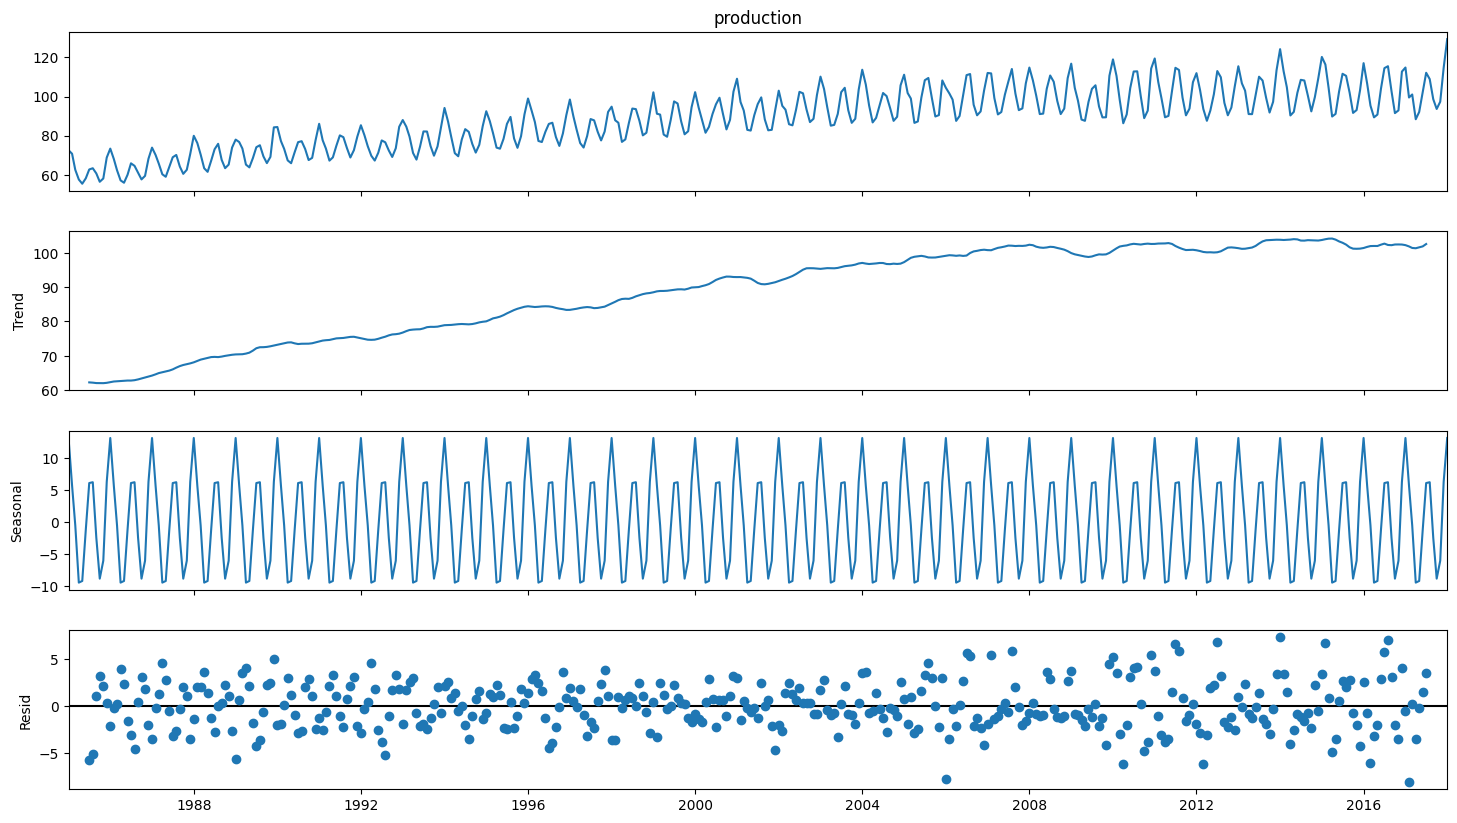

In [10]:
result=seasonal_decompose(d_production['production'], model='additive')

trend = result.trend
seasonal = result.seasonal
residual = result.resid

p = result.plot();

p.set_size_inches(16, 9)

### Checking data is stationary or (non-stationary-null hypothesis)

In [11]:
from statsmodels.tsa.stattools import adfuller
res = adfuller(d_production['production'])
print("p value:--",res[1])

p value:-- 0.18621469116586592


* 0.18 > 0.05. 
* p value is greater than the threshold (0.05)
* We accept the null hypothesis

In [12]:
len(d_production)

397

### Spliting data for training and testing and finally plotting it:

In [13]:
train_data, test_data = d_production[0:300], d_production[300:398]

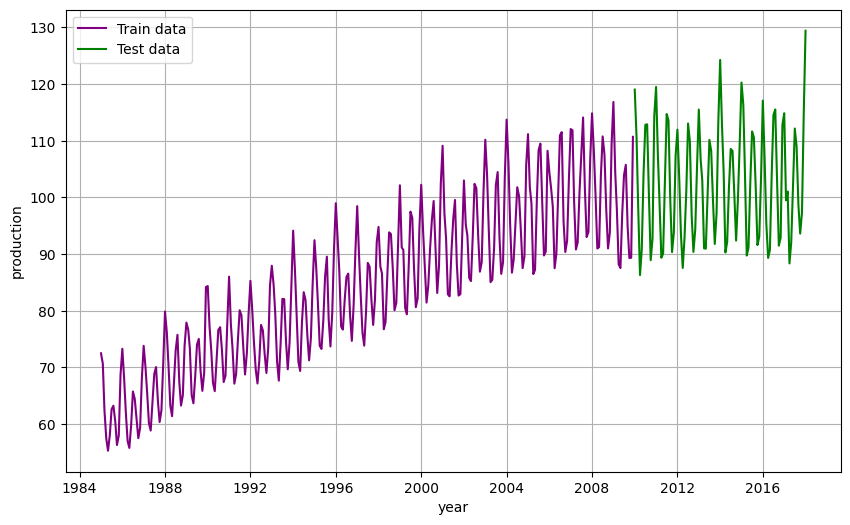

In [14]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('year')
plt.ylabel('production')
plt.plot(train_data['production'], 'purple', label='Train data')
plt.plot(test_data['production'], 'green', label='Test data')
plt.legend()

In [15]:
stepwise_model = auto_arima(train_data['production'],
                           max_p=6, max_q=6,
                           seasonal=False,
                           trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2018.656, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1978.539, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1930.403, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2016.755, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1932.048, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1928.501, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1930.143, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1863.609, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1841.157, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1812.191, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=1811.480, T

**Finding p, d, and q:**

In [16]:
p = range(0,6)
q = range(0,6)
d = range(0,2)

pdq_values_list = list(itertools.product(p,d,q))

len(pdq_values_list)

72

In [17]:
arima_order = []
rmse = []

for values in pdq_values_list:
    temp_Moodel = ARIMA(train_data['production'],order=values).fit()
    p = temp_Moodel.predict(start = 0,end = 299)
    error = np.sqrt(mean_squared_error(train_data['production'],p))
    arima_order.append(values)
    rmse.append(error)

In [18]:
final_values = pd.DataFrame(index = arima_order, data = rmse, columns = ['error'] )
final_values.sort_values(['error'])

,error
"(3, 0, 5)",3.137083
"(3, 0, 4)",3.183228
"(4, 0, 4)",3.216920
"(5, 0, 2)",3.220062
"(3, 0, 3)",3.221666
...,...
"(0, 1, 1)",7.342676
"(1, 1, 0)",7.764530
"(0, 1, 0)",8.172054
"(0, 0, 1)",8.496603


### Creating the model:

In [19]:
model_fit = ARIMA(train_data['production'], order=(3,0,5)).fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             production   No. Observations:                  300
Model:                 ARIMA(3, 0, 5)   Log Likelihood                -764.041
Date:                Mon, 14 Aug 2023   AIC                           1548.082
Time:                        17:36:46   BIC                           1585.120
Sample:                    01-01-1985   HQIC                          1562.905
                         - 12-01-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         84.3454    483.552      0.174      0.862    -863.399    1032.089
ar.L1          1.9977      0.004    496.013      0.000       1.990       2.006
ar.L2         -1.9955      0.006   -340.726      0.0

In [20]:
#Prediction

prediction = model_fit.predict(start = 300,end = 396)
prediction

2010-01-01    116.761797
2010-02-01    111.472271
2010-03-01     98.644002
2010-04-01     88.804844
2010-05-01     90.930681
                 ...    
2017-09-01     98.095661
2017-10-01     89.644850
2017-11-01     92.226839
2017-12-01    103.233935
2018-01-01    111.639142
Freq: MS, Name: predicted_mean, Length: 97, dtype: float64

In [21]:
print(len(prediction))
p = pd.DataFrame()
p['production'] = prediction
p.index = test_data.index

97


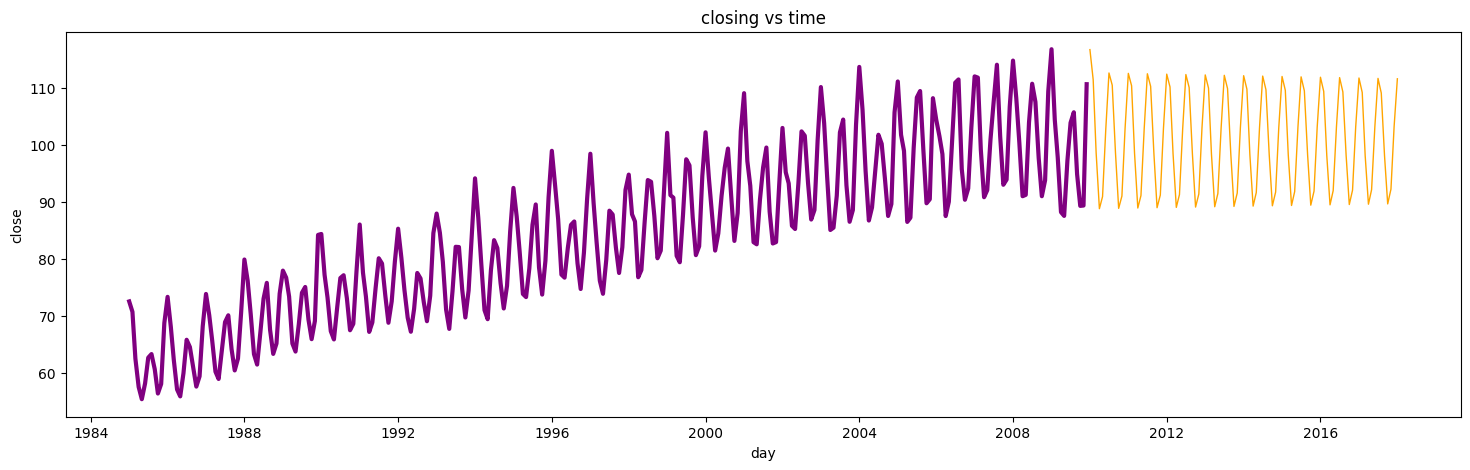

In [22]:
plt.figure(figsize=(18,5))
plt.plot(train_data.index, train_data['production'],color="purple", linewidth=3.0)
plt.plot( p['production'],color="orange", linewidth=1.0)
plt.title('closing vs time')
plt.xlabel('day')
plt.ylabel('close')
plt.show()

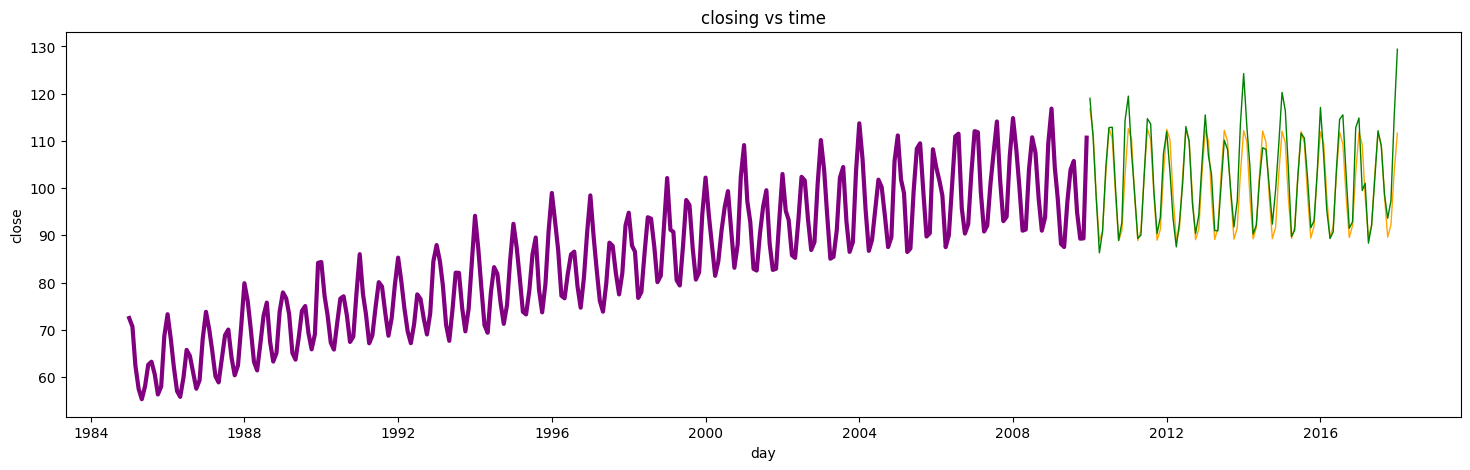

In [23]:
plt.figure(figsize=(18,5))
plt.plot(train_data.index, train_data['production'],color="purple", linewidth=3.0)
plt.plot( p['production'],color="orange", linewidth=1.0)
plt.plot( test_data['production'],color="green", linewidth=1.0)
plt.title('closing vs time')
plt.xlabel('day')
plt.ylabel('close')
plt.show()

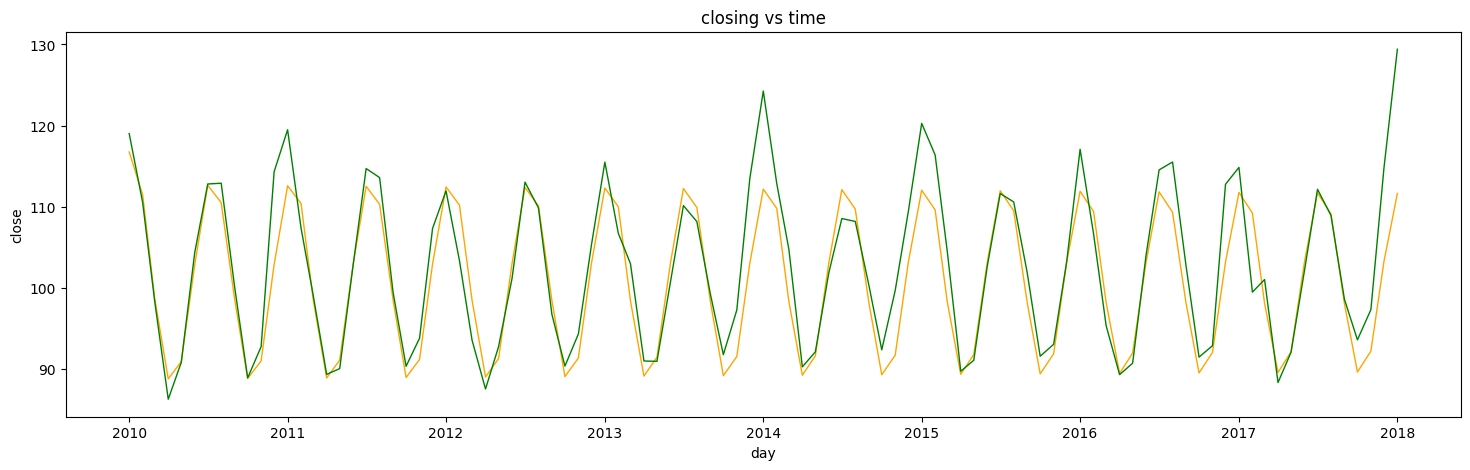

In [25]:
plt.figure(figsize=(18,5))
plt.plot( p['production'],color="orange", linewidth=1.0)
plt.plot( test_data['production'],color="green", linewidth=1.0)
plt.title('closing vs time')
plt.xlabel('day')
plt.ylabel('close')
plt.show()